# Imported Libraries

In [225]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,accuracy_score, precision_score, recall_score
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt


# Helper Functions

In [ ]:
features = ['Weight', 'Body mass index', 'Systolic', 'Diastolic', 'Gender', 'Age',
       'Glycohemoglobin', 'Cholesterol', 'High-density lipoprotein (HDL)',
       'Albumin', 'Alanine aminotransferase (ALT)',
       'Aspartate aminotransferase (AST)', 'Alkaline phosphatase (ALP)',
       'Gamma-glutamyl transferase (GGT)', 'Glucose', 'Iron',
       'Lactate dehydrogenase (LDH)', 'Phosphorus', 'Bilirubin', 'Protein',
       'Triglycerides', 'Uric acid', 'Creatinine', 'White blood cells',
       'Basophils', 'Red blood cells', 'Hemoglobin', 'Red blood cell width',
       'Platelet count', 'Mean volume of platelets', 'Moderate-work',
       "Diabetes_Don't know", 'Diabetes_No', 'Diabetes_Yes', 'Blood related diabetes_No',
       'Blood related diabetes_Refused', 'Blood related diabetes_Yes',
       'Vigorous-work_No', 'Vigorous-work_Refused',
       'Vigorous-work_Unable to do activity', 'Vigorous-work_Yes']

In [247]:
def process_and_load_data(data = pd.DataFrame, target = str):
    #The input should only be a Pandas DataFrame 
 
    #This creates split datasets for training, testing, and validation
    #Additionally it prepares the input data sets for model fitting and predicting
   
    smote = SMOTE(random_state=42)
    


    X = data.drop(target, axis = 1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


    scaler = StandardScaler()
    X_train_resampled = scaler.fit_transform(X_train_resampled)
    X_test = scaler.transform(X_test)
    X_val =  scaler.transform(X_val)


  

    return X_train_resampled, X_test, X_val, y_train_resampled, y_test, y_val
    


In [220]:
def model_assessment(predictions, actuals):
    
   

    #Overall
    overall_accuracy = accuracy_score(actuals, predictions)
    overall_recall = recall_score(actuals, predictions)
    overall_precision = precision_score(actuals, predictions)



    results = pd.DataFrame({
        'Group': ['Overall'],
        'Accuracy': [overall_accuracy],
        'Recall': [overall_recall],
        'Precision': [overall_precision]
    })

    return results

In [224]:
def thresholds_assessment(raw_predictions, actuals, thresholds = list):
    accs =[]
    recalls = []
    precs = []
    for threshold in thresholds:
        new_preds = (raw_predictions >= threshold).astype(int)
        accs.append(accuracy_score(actuals, new_preds))
        recalls.append(recall_score(actuals, new_preds))
        precs.append(precision_score(actuals, new_preds))
    return {'Accuracy': accs, 'Recall': recalls, 'Precision': precs}

# Data Load & Processing

In [167]:
df = pd.read_parquet('data/nhanes_data_processed.parquet')
df.head()

,Weight,Body mass index,Systolic,Diastolic,Gender,Age,Diabetes,Glycohemoglobin,Cholesterol,High-density lipoprotein (HDL),...,Basophils,Red blood cells,Hemoglobin,Red blood cell width,Platelet count,Mean volume of platelets,Coronary heart disease,Blood related diabetes,Moderate-work,Vigorous-work
4,92.5,29.10,122.0,82.0,Male,597.0,No,5.5,7.21,1.08,...,5.397605e-79,5.13,14.5,13.1,209.0,10.4,No,No,17.0,Yes
6,78.0,29.39,130.0,78.0,Female,712.0,No,5.8,6.34,2.73,...,5.397605e-79,4.60,13.4,14.3,244.0,8.2,No,Yes,3.0,No
9,111.8,30.94,152.0,98.0,Male,518.0,No,5.5,3.62,1.31,...,5.397605e-79,5.00,15.4,13.7,167.0,9.4,No,Don't know,13.0,Don't know
13,75.5,27.33,142.0,56.0,Male,973.0,No,5.8,4.50,1.04,...,5.397605e-79,5.32,16.6,12.4,160.0,9.0,No,No,9.0,Yes
14,81.6,26.68,106.0,68.0,Female,459.0,No,4.6,5.15,1.49,...,5.397605e-79,4.14,13.3,11.9,255.0,7.7,No,No,13.0,Yes


### One Hot Encode the Categorical Features

In [169]:
# Male = 1
# Female = 0
# CHD Positive = 1
# CHD Negative = 1
df['Gender'] = df['Gender'].mask(df['Gender'] == 'Male', 1).mask(df['Gender'] == 'Female', 0)
df['Coronary heart disease'] = df['Coronary heart disease'].mask(df['Coronary heart disease'] == 'Yes', 1).mask(df['Coronary heart disease'] == 'No', 0)
categorical_cols = ['Diabetes', 'Blood related diabetes', 'Vigorous-work']

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

### Create Train/Test/Validation Sets

In [170]:
df['Coronary heart disease'].value_counts()

Coronary heart disease
0    43952
1     1868
Name: count, dtype: int64

In [172]:
print(df['Coronary heart disease'].dtype)
df['Coronary heart disease'] = df['Coronary heart disease'].astype(int)

object


In [267]:
X_train, X_test, X_val, y_train, y_test, y_val = process_and_load_data(df, 'Coronary heart disease')

# Base Logistic Regression Model

In [268]:

log_reg = sklearn.linear_model.LogisticRegression(class_weight="balanced", max_iter = 100)

In [269]:
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Default Threshold of 0.5

In [270]:
y_pred = log_reg.predict(X_test)

In [271]:
y_pred

array([0, 0, 0, ..., 0, 0, 0], shape=(9164,))

In [272]:
y_pred = log_reg.predict(X_test)
model_assessment(X_test,y_pred, y_test)

,Group,Accuracy,Recall,Precision
0,Overall,0.893169,0.450135,0.177282


In [273]:
y_pred_val = log_reg.predict(X_val)
model_assessment(X_val,y_pred_val, y_val)

,Group,Accuracy,Recall,Precision
0,Overall,0.896006,0.470255,0.178112


### Testing with Different Thresholds

### Test Set

In [261]:
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

In [262]:
thresholds = np.arange(0.1, 1, 0.1)
metrics = thresholds_assessment(y_pred_proba, y_test, thresholds)

### Plots

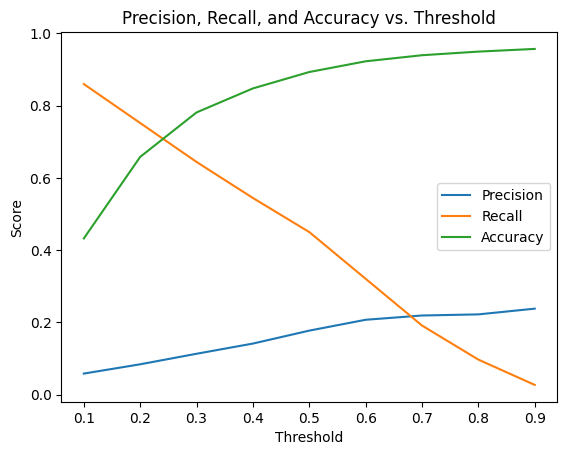

In [263]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()

### Validation Set

In [264]:
y_pred_proba = log_reg.predict_proba(X_val)[:, 1]

In [265]:
thresholds = np.arange(0.1, 1, 0.1)
metrics = thresholds_assessment(y_pred_proba, y_test, thresholds)

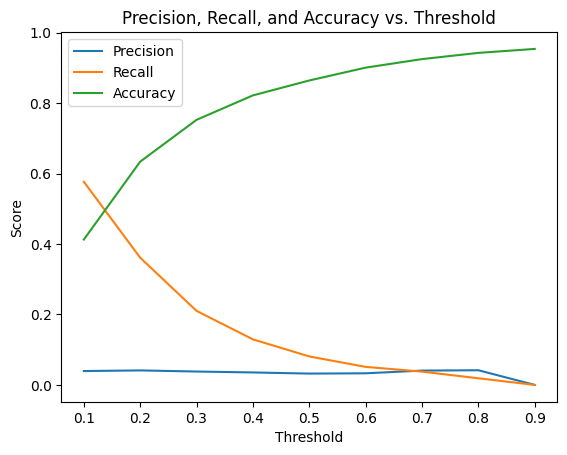

In [266]:
plt.plot(thresholds, metrics['Precision'], label='Precision')
plt.plot(thresholds, metrics['Recall'], label='Recall')
plt.plot(thresholds, metrics['Accuracy'], label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.show()